In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import LogNorm

plt.style.use(["science","bright","grid"])

V_WRITES    = [0.01, 0.02, 0.04]
T_WRITES    = [13.9, 1.6, 0.3]
T_WAITS     = [0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1., 1.5, 2., 3., 5.,
               7., 10., 15., 20., 30., 50., 70., 100., 150., 200., 300., 500., 700., 1000.]
N_VOLT      = 50000
TIME_STEP   = 1e-11
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/two_steps/old_sweep/"
N_PARTICLES = 9
ELE_AC      = 0.160217662

def lin_func(x, a, b, c):
    return a*(x-b) + c
def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)
def exp_decay(t, tau, A):
    return 1 + A*np.exp(-t/tau)
topo = {"Nx": N_PARTICLES,"Ny": N_PARTICLES,
        "e_pos": [[(N_PARTICLES-1)//2, 0],[0, 0],[N_PARTICLES-1, 0],
                [0, (N_PARTICLES-1)//2],[N_PARTICLES-1, (N_PARTICLES-1)//2],
                [0, N_PARTICLES-1],[N_PARTICLES-1, N_PARTICLES-1],[(N_PARTICLES-1)//2, N_PARTICLES-1]],
        "electrode_type": ['constant']*8}
sim_class = Simulation(topo)
cap_mat   = sim_class.get_capacitance_matrix()

In [27]:
def paired_pulse(V_write, t_write, t_wait, dt, N_electrodes=8, input_pos=0):
    
    # Time intervals
    t1_end      = t_write
    t_wait_end  = t_write + t_wait
    t2_end      = t_write + t_wait + t_write

    # Total steps
    n_steps     = int(np.ceil(t2_end / dt))
    t_series    = np.arange(0, n_steps)*dt

    # Voltage Time Series
    V_series        = np.zeros(n_steps)
    pulse1_indices  = t_series < t1_end
    V_series[pulse1_indices] = V_write
    pulse2_indices  = t_series >= t_wait_end
    V_series[pulse2_indices] = V_write

    # Define Input Position
    voltages                = np.zeros((n_steps,N_electrodes+1))
    voltages[:,input_pos]   = V_series

    return t_series, voltages

In [163]:
t   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[0][1:]*1e9 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
x   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[1][1:,0]*1000 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
q   = {V : {t : [pd.read_csv(f"{FOLDER}mean_state_Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv").values for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
y   = {V : {t : [pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Observable'].values*1e-6 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
y_e = {V : {t : [pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Error'].values*1e-6 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}

### State-based

In [ ]:
ppr     = {}
r_decay = {}
taus = np.zeros((len(V_WRITES), len(T_WRITES)))
for n, v_write in enumerate(V_WRITES):
    ppr2 = {}
    r_decay2 = {}
    for m, t_write in enumerate(T_WRITES):
        lt = []
        lt2 = []
        for i, t_wait in enumerate(T_WAITS):
            q_vals  = q[v_write][t_write][i].copy()
            idx_w   = np.where(q_vals[:,0] == 0.0)[0]
            t1_end  = idx_w[0] - 1
            t2_sta  = idx_w[-1] + 1
            q0  = cap_mat @ q_vals.copy()[0,8:]
            q1  = cap_mat @ q_vals.copy()[t1_end,8:]
            q2  = cap_mat @ q_vals.copy()[t2_sta,8:]
            q3  = cap_mat @ q_vals.copy()[-1,8:]
            R1  = np.linalg.norm(q1 - q0)
            R2  = np.linalg.norm(q3 - q2)
            RV  = R2 / R1
            lt.append(RV)

            q1  = cap_mat @ q_vals.copy()[idx_w[0],8:]
            q2  = cap_mat @ q_vals.copy()[idx_w[-1],8:]
            Rd  = (R1 - np.linalg.norm(q2 - q1)) / R1
            lt2.append(Rd)
            
        ppr2[t_write] = lt
        r_decay2[t_write] = lt2
        M_t = 1.0 - np.array(lt)
        M_m = M_t[0]
        r_t = M_t / M_m
        try:
            idx = np.where(r_t<0)[0][0]
        except:
            idx = len(r_t)
        t_v = np.array(T_WAITS).copy()[:idx]
        tau = np.trapz(t_v * r_t[:idx], x=t_v) / np.trapz(r_t[:idx], x=t_v)
        taus[n,m] = tau
    ppr[v_write] = ppr2
    r_decay[v_write] = r_decay2

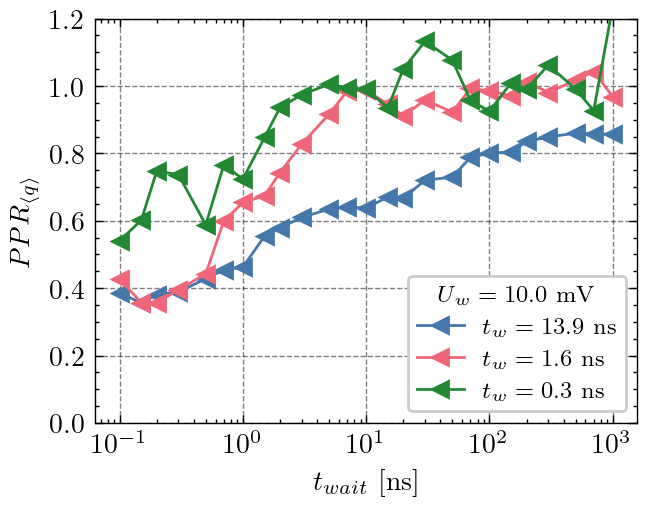

In [188]:
markers = ['o','s','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.01
for t_write in T_WRITES:
    x_plot  = np.array(T_WAITS).copy()
    y_plot  = np.array(ppr[v_write][t_write]).copy()
    ax.plot(x_plot, y_plot, label=f"$t_w = {t_write}$ ns", marker=markers[i], ls='-')
ax.set_xscale('log')
_ = ax.set_ylim(0,1.2)
_ = ax.legend(fontsize='small', ncol=1, loc='lower right', title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_ = ax.set_ylabel("$PPR_{\\langle q \\rangle}$")
_ = ax.set_xlabel("$t_{wait}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_{v_write}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_{v_write}.svg", transparent=True)

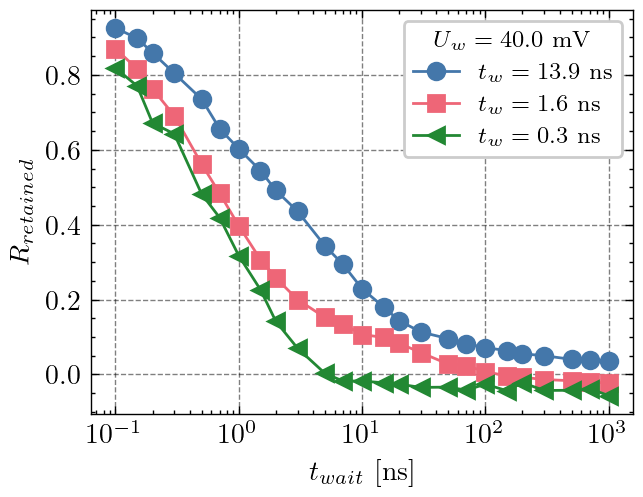

In [274]:
markers = ['o','s','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.04
for i, t_write in enumerate(T_WRITES):
    x_plot  = np.array(T_WAITS).copy()
    y_plot  = np.array(r_decay[v_write][t_write]).copy()
    ax.plot(x_plot, y_plot, label=f"$t_w = {t_write}$ ns", marker=markers[i], ls='-')
ax.set_xscale('log')
_ = ax.legend(fontsize='small', ncol=1, loc='upper right', title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_ = ax.set_ylabel("$R_{retained}$")
_ = ax.set_xlabel("$t_{wait}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_R_decay_{v_write}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_R_decay_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_R_decay_{v_write}.svg", transparent=True)

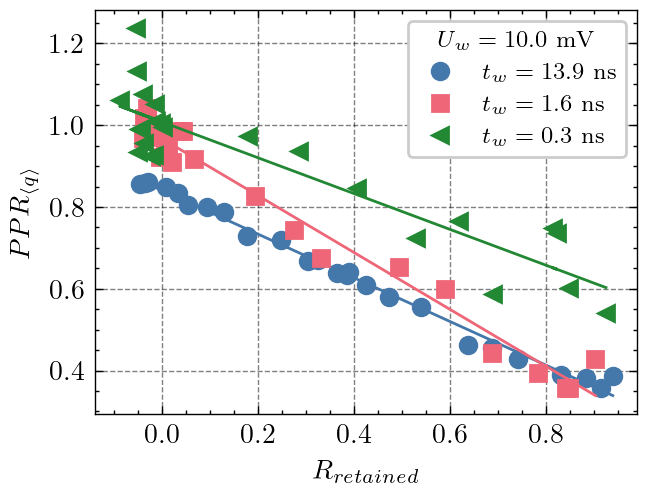

In [277]:
markers = ['o','s','<','>']
v_write = 0.01
fig, ax = plt.subplots(dpi=200)
for i, t_write in enumerate(T_WRITES):
    x_plot  = np.array(r_decay[v_write][t_write]).copy()
    y_plot  = np.array(ppr[v_write][t_write]).copy()
    pp      = ax.plot(x_plot, y_plot, marker=markers[i], ls='', label=f"$t_w = {t_write}$ ns", )
    p, cov  = curve_fit(lin_func, x_plot, y_plot)
    ax.plot(x_plot, lin_func(x_plot, *p), color=pp[0].get_color())
_ = ax.legend(fontsize='small', ncol=1, loc='upper right', title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_ = ax.set_ylabel("$PPR_{\\langle q \\rangle}$")
_ = ax.set_xlabel("$R_{retained}$")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_R_decay_{v_write}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_R_decay_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_vs_R_decay_{v_write}.svg", transparent=True)

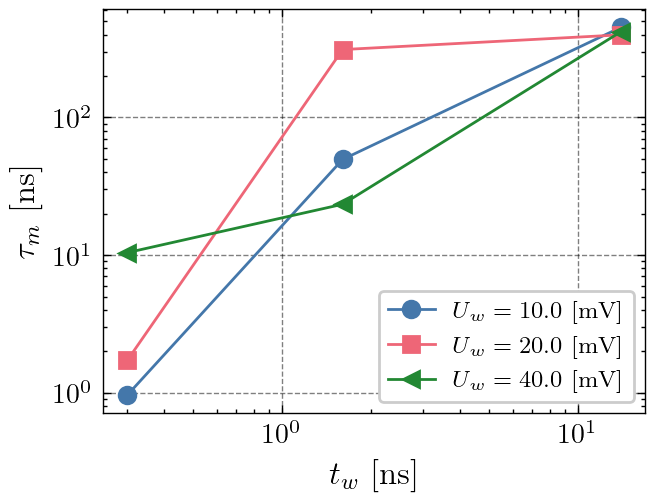

In [172]:
markers = ['o','s','<','>']
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(V_WRITES):
    ax.plot(T_WRITES, taus[i,:], marker=markers[i], label=f'$U_w = {V*1000}$ [mV]')
ax.set_xscale('log')
ax.set_yscale('log')
_ = ax.set_xlabel("$t_w$ [ns]", fontsize='large')
_ = ax.set_ylabel("$\\tau_m$ [ns]", fontsize='large')
_ = ax.legend(fontsize='small')
fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_tau_m_vs_tw.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_tau_m_vs_tw.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_tau_m_vs_tw.svg", transparent=True)

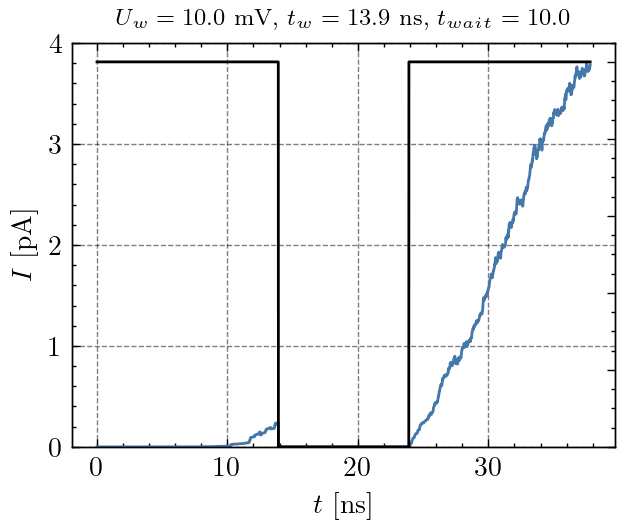

In [206]:
v_write = 0.01
t_write = 13.9
idx     = 12

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t[v_write][t_write][idx], y[v_write][t_write][idx])
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$I$ [pA]")
ax.set_ylim(0)
ax.set_title(f'$U_w = {v_write*1000}$ mV, $t_w = {t_write}$ ns, '+'$t_{wait} = '+f'{T_WAITS[idx]}$', fontsize='small')
# ax.set_yscale('log')
# ax.set_ylim(1e-10)
ax2 = ax.twinx()  
ax2.plot(t[v_write][t_write][idx], x[v_write][t_write][idx], color='black')
ax2.grid(False)
ax2.set_ylim(0)
_ = ax2.set_yticklabels('')
fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_out_response_Uw={v_write}_tw={t_write}_twa={T_WAITS[idx]}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_out_response_Uw={v_write}_tw={t_write}_twa={T_WAITS[idx]}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_out_response_Uw={v_write}_tw={t_write}_twa={T_WAITS[idx]}.svg", transparent=True)

### Current based

In [320]:
ppr     = {}
r_decay = {}
taus = np.zeros((len(V_WRITES), len(T_WRITES)))
for n, v_write in enumerate(V_WRITES):
    ppr2 = {}
    r_decay2 = {}
    for m, t_write in enumerate(T_WRITES):
        lt = []
        lt2 = []
        for i, t_wait in enumerate(T_WAITS):
            q_vals  = q[v_write][t_write][i].copy()
            idx_w   = np.where(q_vals[:,0] == 0.0)[0]
            t1_end  = idx_w[0] - 1
            t2_sta  = idx_w[-1] + 1
            q0  = cap_mat @ q_vals.copy()[0,8:]
            q1  = cap_mat @ q_vals.copy()[t1_end,8:]
            q2  = cap_mat @ q_vals.copy()[t2_sta,8:]
            q3  = cap_mat @ q_vals.copy()[-1,8:]
            R1  = (np.sum(q1) - np.sum(q0)) / t_write
            R2  = (np.sum(q3) - np.sum(q2)) / t_write
            RV  = R2 / R1
            lt.append(RV)

            q1  = cap_mat @ q_vals.copy()[idx_w[0],8:]
            q2  = cap_mat @ q_vals.copy()[idx_w[-1],8:]
            Rd  = (R1 - np.linalg.norm(q2 - q1)) / R1
            lt2.append(Rd)
            
        ppr2[t_write] = lt
        r_decay2[t_write] = lt2
        M_t = 1.0 - np.array(lt)
        M_m = M_t[0]
        r_t = M_t / M_m
        try:
            idx = np.where(r_t<0)[0][0]
        except:
            idx = len(r_t)
        t_v = np.array(T_WAITS).copy()[:idx]
        tau = np.trapz(t_v * r_t[:idx], x=t_v) / np.trapz(r_t[:idx], x=t_v)
        taus[n,m] = tau
    ppr[v_write] = ppr2
    r_decay[v_write] = r_decay2

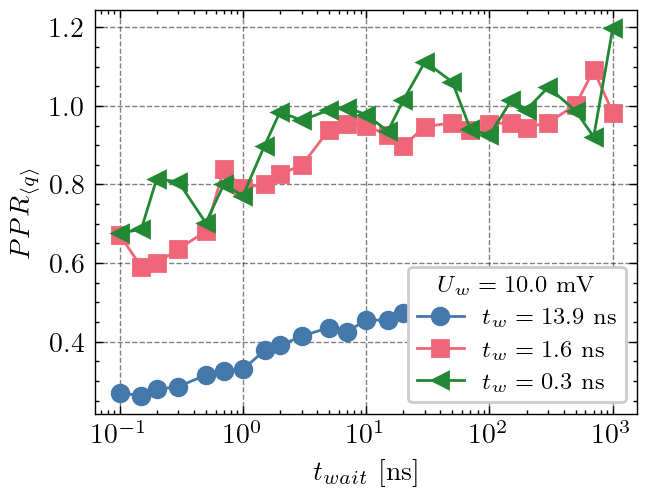

In [ ]:
markers = ['o','s','<','>']
fig, ax = plt.subplots(dpi=200)
v_write = 0.01
for i, t_write in enumerate(T_WRITES):
    x_plot  = np.array(T_WAITS).copy()
    y_plot  = np.array(ppr[v_write][t_write]).copy()
    ax.plot(x_plot, y_plot, label=f"$t_w = {t_write}$ ns", marker=markers[i], ls='-')
ax.set_xscale('log')
_ = ax.legend(fontsize='small', ncol=1, loc='lower right', title=f'$U_w = {1000*v_write}$ mV', title_fontsize='small')
_ = ax.set_ylabel("$PPR_{\\langle q \\rangle}$")
_ = ax.set_xlabel("$t_{wait}$ [ns]")

fig.savefig(f"plots/png/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_current_{v_write}.png", transparent=False)
fig.savefig(f"plots/pdf/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_current_{v_write}.pdf", transparent=False)
fig.savefig(f"plots/svg/two_steps/N={N_PARTICLES}_N={N_PARTICLES}_PPR_current_{v_write}.svg", transparent=True)